***Identify a deafault client (CREDIT SCORING)***

<img src = 'https://www.nationalvanguard.org/wp-content/uploads/2016/03/debt-slave.jpg' width='400px' >

<a id="sec1"></a>
# [Description](#sec1)

Enter text here

<a id="sec1.1"></a>
## [Features Defination](sec1.1)

client_id -  client ID

education - the level of education

sex - borrowe's gender

age - borrowers age

car - has(has no) car

car_type - flag of car type

decline_app_cnt - number of rejected past applications

good_work - good job flag

bki_request_cnt - number of requests to Credit bureau

home_address - home address categorizer 

work_address - work address categorizer 

income - borrower's income

foreign_passport - has (has no) traveling passport

sna - Relationships of borrower with the bank's clients

first_time - how old the information about the borrower was

score_bki - score based on data from Credit bureau

region_rating - region rating

app_date - application date

default - has (has no) default

<a id="sec2"></a>
# [INDEX](#sec2)
1. [Description](#sec1)
    * [1.1 Features Defination](#sec1.1)
2. [INDEX](#sec2)
3. [IMPORT LIBRARRIES](#sec3)
4. [Functions and Classes](#sec4)
5. [Load and Chek the Dataset](#sec5)
    * [Data Types](#sec5.1)
    * [Pandas Profiling](#sec5.2)
6. [EDA](#sec6)
    * [Bolean Feature analysis](#sec6.1)
    * [Categorical Feature analysis](#sec6.2)
    * [Numerical Feature analysis](#sec6.3)
    * [Date_Time analysis](#sec6.4)
7. [Naive Model](#sec7)
8. [Feature Engineering](#sec8)

5. [Visualization](#sec5)
    * [5.1 Correclation](#sec5.1)
    * [Significance of continuous variables ](#sec5.2)
6. [Categorical Vars](#sec6)

<a id="sec3"></a>
# [IMPORT LIBRARRIES](sec3)

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from jupyterthemes import jtplot

warnings.filterwarnings("ignore")
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
%matplotlib inline

In [ ]:
# fix the version of the packages so that the experiments are reproducible:
#!pip freeze > requirements.txt

In [2]:
# Lock a RANDOM SEED to keep experiments reproducible.
RANDOM_SEED = 5

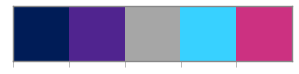

In [3]:
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

<a id="sec4"></a>
# [Functions and Classes](#sec4)

In [4]:
def pandas_report(data):
    ''' Function is called for generating of dataset profile-report'''

    profile = data.profile_report(
        title='Credit Scoring',
        progress_bar=False,
        correlations={
            'pearson': {'calculate': True,
                        'warn_high_correlations': True,
                        'threshold': 0.9},
            'spearman': {'calculate': True,
                        'warn_high_correlations': True,
                        'threshold': 0.9},
            'kendall': {'calculate': False},
            'phi_k': {'calculate': False},
            'cramers': {'calculate': False}        
        },
        
        interactions={
            'continuous': True,
            'targets': []
        },
        missing_diagrams={
            'heatmap': True,
            'dendrogram': True,
            'matrix': True
        },
        vars={
            'cat' : {'n_obs':10}
        }
    )
    
    return profile

In [4]:
### NOT IN USE
def get_boxplot(column):
    '''Function is called to plot boxplots'''
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='default', hue='default')
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [5]:
class Preprocessing:
    def __init__(self,data):
        self.data = data
#         self.column = column
    
    def label_encoder(self,column):
        le = LabelEncoder()
        self.data[column] = le.fit_transform(self.data[column])
        
    def hot_enc(self,column):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.data[[column]]))
        aux_df.columns = ohe.get_feature_names(['hot_encode'])
        self.data = pd.concat([self.data, aux_df], axis=1)
        return self.data       

In [6]:
def pre_processing(column,data):
    '''Function is called to encode feature'''
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])

In [7]:
def missing_vars(data,col = 'education', random_proba=True):
    # With using probability and random choise

    if random_proba:
        col_name = data[col].value_counts(
        ).index.to_list()  # Получаем список значений
        col_distr = data[col].value_counts(
            normalize=True).values  # Получаем список вероятностей
        missing = data[col].isnull()  # Флаги с наличием пропусков
        # Подставляем значения из списка имен в соответствии в вероятностью встречи имени
        data.loc[missing, [col]] = np.random.choice(
            col_name, size=len(data[missing]), p=col_distr)
    
    # Using  most common in  column
    data[col] = data[col].fillna(
    data[col].value_counts().index[0])

In [8]:
def corr_matrix(data, det=True, pltx = 10, plty=10):
    X = data.corr()
    if det:
        
        evals,evec = np.linalg.eig(X)
        ev_product = np.prod(evals)
    
        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinat of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')
    
    plt.figure(figsize=(pltx,plty))
    sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [9]:
def get_num_info(col,title = None):
    '''Function is called to plot feture distribution'''
    
    title = title if title is not None else f"Distribution for '{col}"
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5),)
    fig = sm.qqplot(col, fit=True,line='45',ax=ax1)
    fig.suptitle(title,fontsize=20)
    
    sns.distplot(col.values, bins=20, color=colors[1],ax=ax2)
    
#     sns.boxplot(col,width=.2,color=colors[3])
    sns.violinplot(col.values,color=colors[3],bw=.3,cut=1,linewidth=4)
    
    
    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Violinplot')
    
    plt.show()

In [10]:
def detect_outliers(data):
    '''Function is called to detect outliers'''
    q1,q3 = np.percentile(sorted(data),[25,75])
    
    IQR = q3 - q1
    
    l_b = q1 - (1.5 * IQR)
    u_b = q3 + (1.5 * IQR)
    outl_count = len(data[data < l_b]) + len(data[data > u_b])
    
    print(f'Lower Bound: {round(l_b,3)}, Upper Bound {round(u_b,3)}, Outliers Count: {outl_count}')

In [11]:
'''Функция, возвращающая порядковый день в году'''
def get_days_count(x):  
    day = ((x.month-1) * 30)+x.day
    return day
'''Функция, возвращающая количество дней между датой заявки и сегодняшним числом'''
def get_days_beetwen(x):
    curr_date = datetime.today()
    count = (curr_date-x).days
    return count
    
'''Функция, возвращающая флаг подачи заявки в выходной день'''
def if_weekend(x):
    if x.weekday() in [5,6]:
        return 1
    else:
        return 0

def month(x):
    month = x.month
    return month

<a id="sec4"></a>
# [Load and Chek the Dataset](#sec4)

In [12]:
df_train = pd.read_csv(
    r'C:\Users\wangshu202040\The A-Team\sf-dst-scoring\train.csv')
# df_train = pd.read_csv(
#     r'C:\Users\Paul\The_A-team\sf-dst-scoring\train.csv')

df_test = pd.read_csv(
    r'C:\Users\wangshu202040\The A-Team\sf-dst-scoring\test.csv')

# df_test = pd.read_csv(
#     r'C:\Users\Paul\The_A-team\sf-dst-scoring\test.csv')


submission = pd.read_csv(
    r'C:\Users\wangshu202040\The A-Team\sf-dst-scoring\sample_submission.csv')

# submission = pd.read_csv(
#     r'C:\Users\Paul\The_A-team\sf-dst-scoring\sample_submission.csv')

For the processing and EDA, let's concatenate two dataframes into a one.

In [13]:
# For the correct processing of features, combine train and test sets into a one dataset

df_train['sample'] = 1  # train
df_test['sample'] = 0  # test
# as we have to predict rating, in test set we just fill it with 0
#df_test['default'] = 0

df = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # combine sets

In [14]:
display(df.sample(3))
df.info()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
104923,82723,31MAR2014,GRD,F,48,N,N,0,0,-1.123557,2,60,2,3,40000,4,1,N,1,0.0
87440,18244,25JAN2014,SCH,F,60,N,N,0,1,-2.480628,0,50,1,3,13000,2,1,N,1,0.0
13155,6189,13JAN2014,SCH,M,46,N,N,0,0,-2.224518,1,80,2,3,50000,1,4,N,0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

<a id="sec5.1"></a>
## [Data Types](#sec5.1)

In [15]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column Type']
dtype_df.groupby('Column Type').agg('count').reset_index()

,Column Type,Count
0,int64,12
1,float64,2
2,object,6


In [16]:
for i, j in enumerate(df.columns):
    print(j, type(df.loc[1][i]))

client_id <class 'numpy.int64'>
app_date <class 'str'>
education <class 'str'>
sex <class 'str'>
age <class 'numpy.int64'>
car <class 'str'>
car_type <class 'str'>
decline_app_cnt <class 'numpy.int64'>
good_work <class 'numpy.int64'>
score_bki <class 'numpy.float64'>
bki_request_cnt <class 'numpy.int64'>
region_rating <class 'numpy.int64'>
home_address <class 'numpy.int64'>
work_address <class 'numpy.int64'>
income <class 'numpy.int64'>
sna <class 'numpy.int64'>
first_time <class 'numpy.int64'>
foreign_passport <class 'str'>
sample <class 'numpy.int64'>
default <class 'numpy.float64'>


<a id="sec5.2"></a>
## [Pandas Profiling](#sec5.2)

In [ ]:
data_profile = pandas_report(df_train)
data_profile.to_file('result.html') # Check your folder

 - Dataset has 19 features (excluding feature ''Sample)
 
 - Total Number Of observations is 110 148
 
 - Missing values is about 0.04%
 
 - There is no duplicates
 
 
 - ***Client_id*** has 100% unique values 
 
 - ***app_date*** has only 120 distinct values (0.1%). Most of presented dates concentrated in MARCH2014, APRIL2014, FEB2014. We need to process this column in further
 
 - ***education*** Consists 5 distinct categories: 
     
 - - SCH (52%) - School;
 
 - - GRD (31%) - Graduated (Master degree);
 
 - - UGR (13%) - UnderGraduated (Bachelor degree);
 
 - - PGR (1.7%) - PostGraduated;
 
 - - ACD (0.3%) - Academic Degree;
 
 - - Missing (0.4%)
 
 
 We will see how it is impact on a result and probably generate new feature 'Has/Has No Hi-degree education'
 
 - ***sex*** Consists 2 distinct categories:
 - - Female (56%);
 
 - - Male (44%);
 
 
 - ***age*** Is a real Number variable. The distribution is a left-shifted.
 
 -- Minimum	21
 
 -- median	37
 
 -- Mean	39.2
 
 -- Maximum	72
 
 -- Interquartile range (IQR)	18
 
 - ***car*** Is a boolean variable. 67% of borrowers has no car.
 
 
 - ***car_type*** Is a boolean variable which shows whethere the borrower has domestic or foreign car. 81% of borrowers has domesatic.
 
 
 - ***decline_app_cnt*** Is a real number value. Distribution is shifted to the left. Most of values (83%) has zeros which is reasonable. Overwhelimng majority of the observations are located between 0 and 6. We might convert this feature to categorical or ordinal.
 
 -- Maximum	33


 - ***good_work*** Most of borrowers have not good job (83%). It is interesting it here any relations between good job and education? We also want to know, does someone has poor education, bad job and foreign car (Just for fun)
 
 
 - ***score_bki*** Is a real number variable. It consists 93% distinct values. We may note, that it has approximately normal distribution and also consists negative values. Most likely it is already scaled by Standard Scaler.
 
 
 - ***bki_request_cnt*** Is a real number variable with max.requests - 53, min - 0 and median - 1. Most of values scattered from 0 to 8 attempts.
 
 - ***region_rating*** It has kind of grade from 20 up to 80. We would say it is more similar with categoreical feature. Most common rating is 50 (37%)
 
 - ***home_address, work_address*** Is a categorical data with 3 categories.
 
 - ***income*** Biased distribution with large scatter of values - from 1000 to 1 000 000. Here we can try to convert it in a categorical value, assigning the income values to the categories - low income, medium, above medium, etc. 
 
 - ***sna / first_time***  Are categorical features and have 4 categories.  Nothing intersting seems.
 
 - ***foreign_passport*** Is a boolean feature. 67% of borrowers have foreign passport
 
 
 - ***default*** is our target which we have to predict. It is a boolean var, with overwhelming majority of 'good clients'. We may note that this feature is unballanced and the ratio is 1:6.8 which is unballanced a bit. In the feature engenireeng we will try apply under and oversampling and will se results.

<a id="sec6"></a>
# [EDA](#sec6)

<img src = 'https://media.makeameme.org/created/analyze-the-data.jpg' width = '400px' >

In [18]:
bool_cols = ['sex','car','car_type','good_work','foreign_passport']
cat_cols = ['education','region_rating','home_address','work_address','sna','first_time']
num_cols = ['age','decline_app_cnt','income','bki_request_cnt','score_bki']

<a id="sec6.1"></a>
## [Boolean feature analysis](#sec6.1)

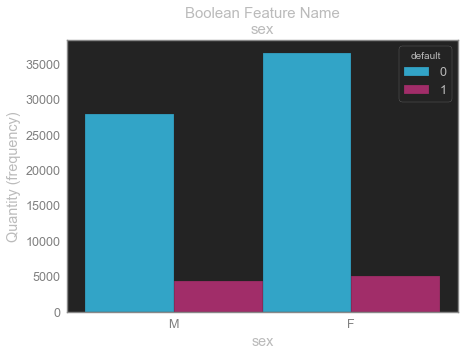

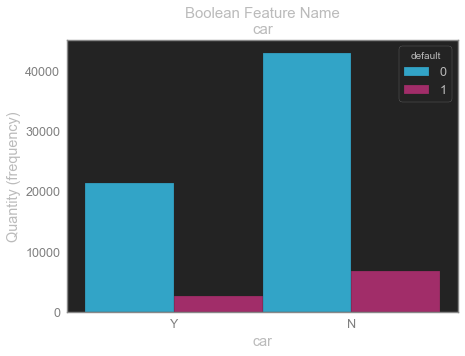

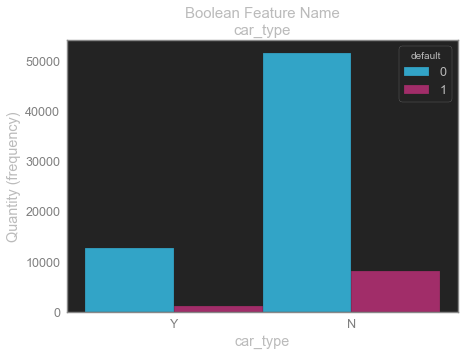

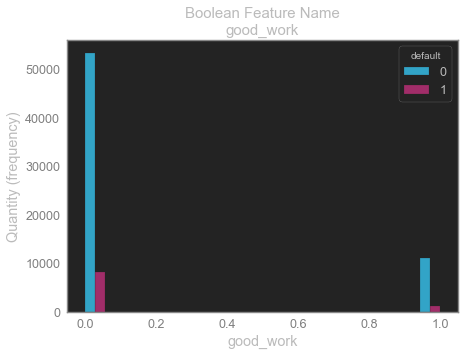

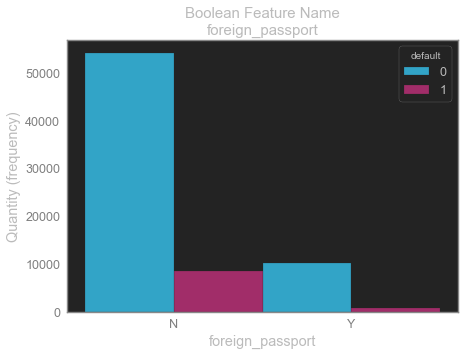

In [19]:
for i in bool_cols:
    plt.figure(figsize=(7, 5))
    ax = plt.subplot()
    sns.histplot(x = i,hue='default',data=df_train,multiple='dodge',palette=[colors[3], colors[4]])
    plt.title('Boolean Feature Name\n' + i, fontsize=15)
    plt.xlabel(i)
    plt.ylabel('Quantity (frequency)')
    plt.yticks()
    ax.tick_params(direction='out', length=0, width=0, colors='grey')

By looking at histograms, we may note that male borrowers tend to be default slightly more than females. 

Borrowers, who has a car could be considered as more reliable.Borrowers who do not have a car tend not to repay their loans twice as often as those who have a car.

Those borrowers who have a domestic car or has no car tend to default more than those who have a foreign car. However, if we want to see the distribution more clear, we need to create a new category in this col: Has a domestic car, has a foreign car, has no car.

People, how have good jobs and foreign passport tend to return loans more often than those, who have bad jobs.

Let's check the how our features statistically significant?

To do so, let's encode it to binary entities.

In [20]:
encoder = Preprocessing(df_train)

In [21]:
for col in bool_cols:
    encoder.label_encoder(col)

df_train.sample(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
19580,30549,06FEB2014,SCH,1,41,1,1,0,0,-2.353286,1,80,2,3,90000,1,4,1,1,1
47297,78105,26MAR2014,PGR,1,34,0,0,0,0,-2.022442,3,70,1,2,86000,4,3,0,0,1
37056,104192,22APR2014,GRD,0,31,0,0,0,0,-2.330104,3,60,2,3,30000,1,4,0,0,1


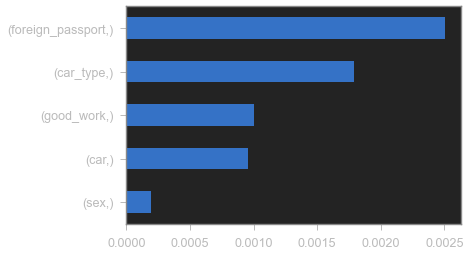

In [22]:
imp_bol = pd.Series(mutual_info_classif(df_train[bool_cols], df_train['default'], 
                                     discrete_features=True), index=[bool_cols])
imp_bol.sort_values(inplace=True)
imp_bol.plot(kind='barh')

Well, most significant feature to client's default is ***foreign_passport*** and ***car_type***

Now, get a look into a correlation matrix

In [ ]:
corr_matrix(df_train[bool_cols])

We have strong correlation between car and car_type. This can be explained by the fact that the column ***car*** indicates the presence of a car, and in the column ***car_type*** the presence of a foreign car, however, the absence of a car or whether the car is domestic is not indicated in ***car_type***. In feature engineering section we will combine information from these to columns into a one. It allows us reduce matrix of features without loosing information.

In addition, car is correlated with sex a bit.

<a id="sec6.2"></a>
## [Categorical Feature analysis](#sec6.2)

Before we do, let's convert categories into a numbers

In [23]:
missing_vars(df_train)

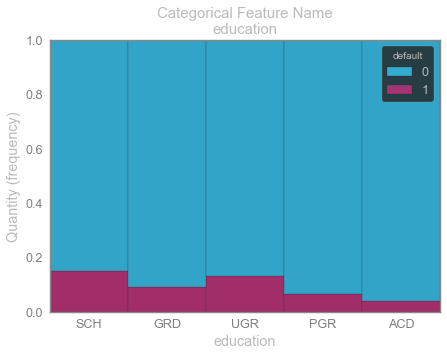

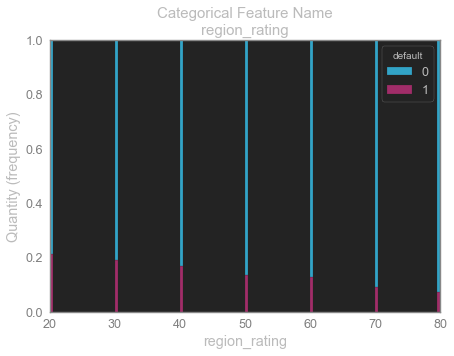

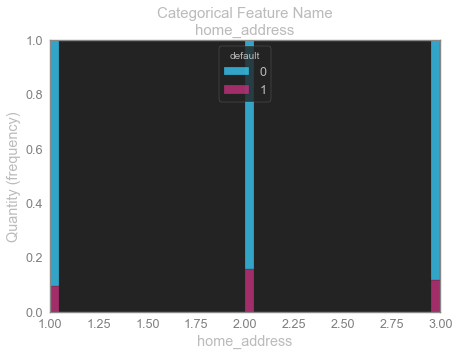

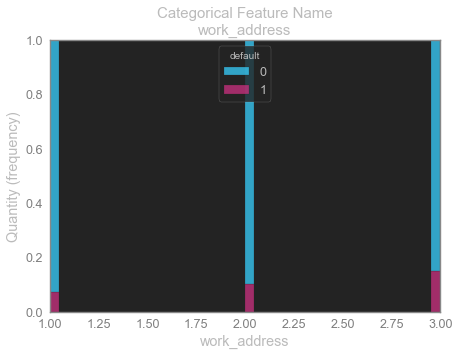

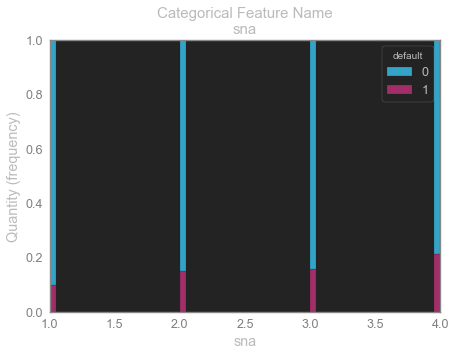

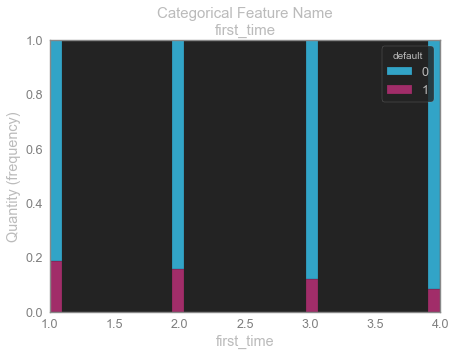

In [24]:
for i in cat_cols:
    plt.figure(figsize=(7, 5))
    ax = plt.subplot()

    sns.histplot(df_train, x=i, hue='default', stat='count', multiple='fill',palette=[colors[3], colors[4]])
    plt.title('Categorical Feature Name\n' + i, fontsize=15)
    plt.xlabel(i)
    plt.ylabel('Quantity (frequency)')
    ax.tick_params(direction='out', length=0, width=5, colors='grey')
      
    plt.show()

Here we can see that people with low-grade education fail to return loans more often than people with high-grade education.

The feature ***region_rating*** gives an interesting insight. The lower rating of the region, the higher share of overdue loan payments.

Home address and work addres are almost the same. We just can see that share of failed borrowers different from each address. Perhaps it has some insights. We will check later.

The category 4 in ***sna*** feature has a higher ratio of failed borrowers. And it falls by reducing the category from 4 to 1.

First time columns also shows us the fall of share of failed borrowers.

Let's see, how the region rating depends on education

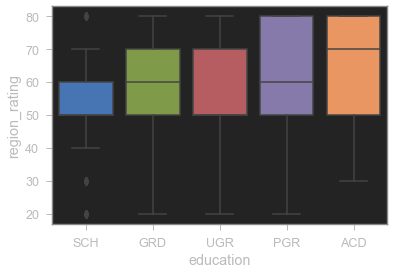

In [44]:
sns.boxplot(x='education',y='region_rating', data=df_train)
plt.show()

People with high level of education prefer to live in a region with higher level

OK, and now, let's see the distribution of the failed borrowern by region_rating

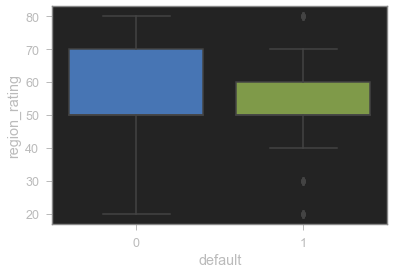

In [45]:
sns.boxplot(x='default',y='region_rating', data=df_train)
plt.show()

We may see that default clients lives in mid level regions. The higher rating of the city, the lower the chance of default

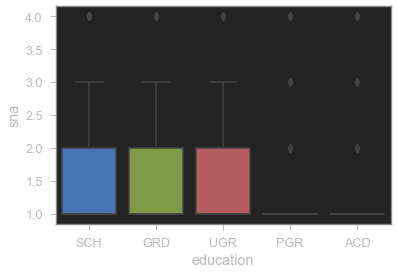

In [46]:
sns.boxplot(x='education',y='sna', data=df_train)
plt.show()

Связи с клиентами банка имеют люди, в основном с низким уровнем образования. Возможно это можно объяснить тем, что люди с низким образованием работают в больших коллективах (заводы, фабрики) и обмен информации лучше.

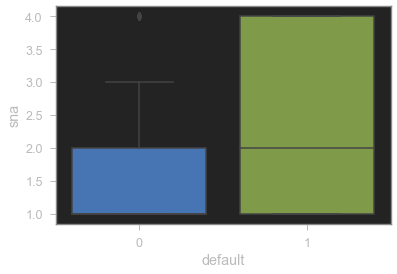

In [47]:
sns.boxplot(x='default',y='sna', data=df_train)
plt.show()

Однако среди таких людей больше должников

Let's do the same as we did for boolean column. Check the significance and correlation

In [24]:
for col in cat_cols:
    encoder.label_encoder(col)

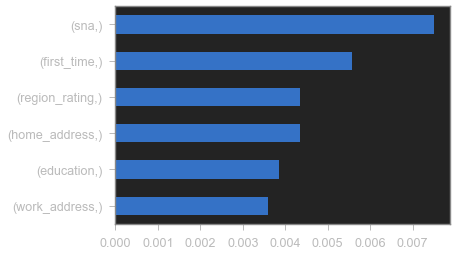

In [25]:
imp_cat = pd.Series(mutual_info_classif(df_train[cat_cols], df_train['default'], 
                                     discrete_features=True), index=[cat_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Rank of Matrix: 8
Determinat of matrix: 0.2891
Shape of matrix: (8, 8)


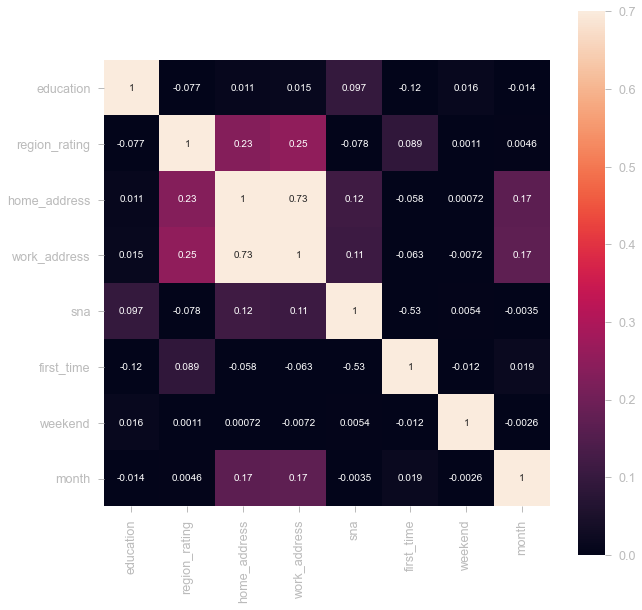

In [53]:
corr_matrix(df_train[cat_cols])

We have quite stong correlation between sna and first_time. Also, these two columns has best significance to a target variable. We may guess, that these two features can be explained as follows: This person has long been a client of the bank and, as a result, has acquired connections with other clients (possibly working together). It is difficult to say what can we do with this information right now. Maybe apply SVD to wtihdraw most usefull info for a model

Home and work addresses also correlated. We need to think what coan we do with these features.

<a id="sec6.3"></a>
## [Numerical Feature analysis](#sec6.3)

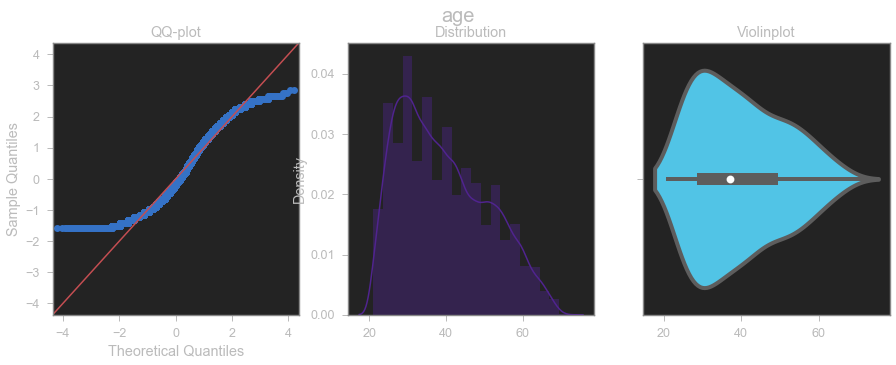

Lower Bound: 3.0, Upper Bound 75.0, Outliers Count: 0


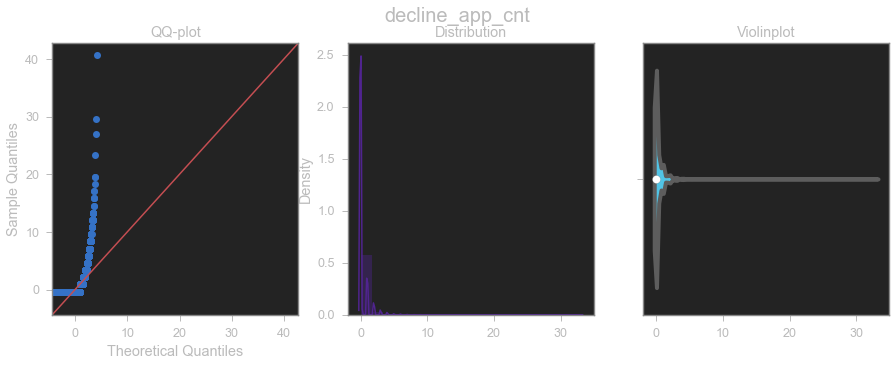

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 12585


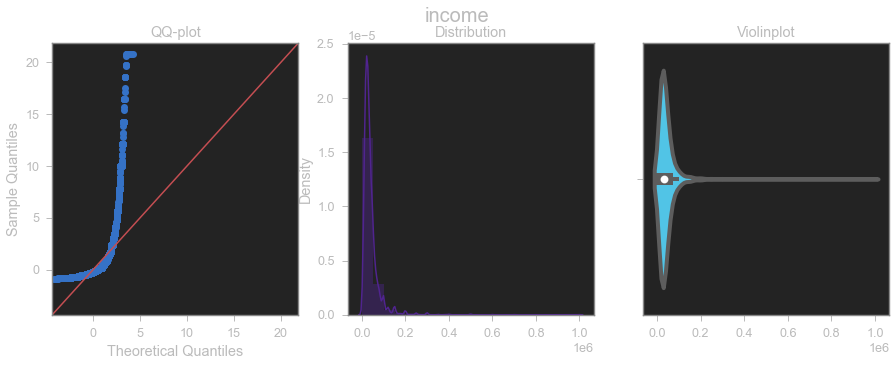

Lower Bound: -22000.0, Upper Bound 90000.0, Outliers Count: 4695


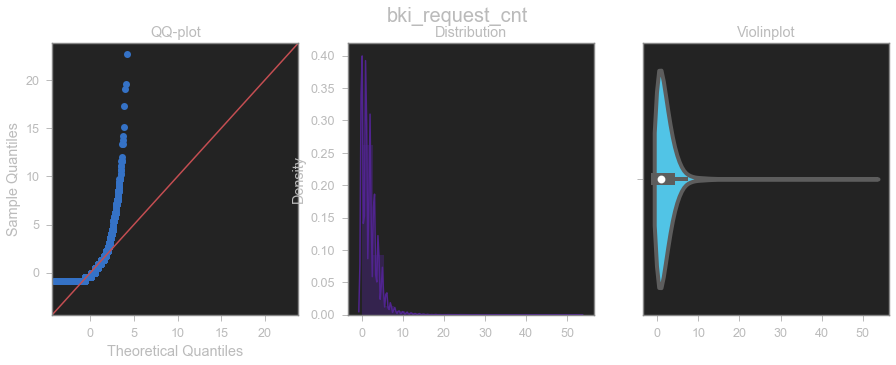

Lower Bound: -4.5, Upper Bound 7.5, Outliers Count: 1755


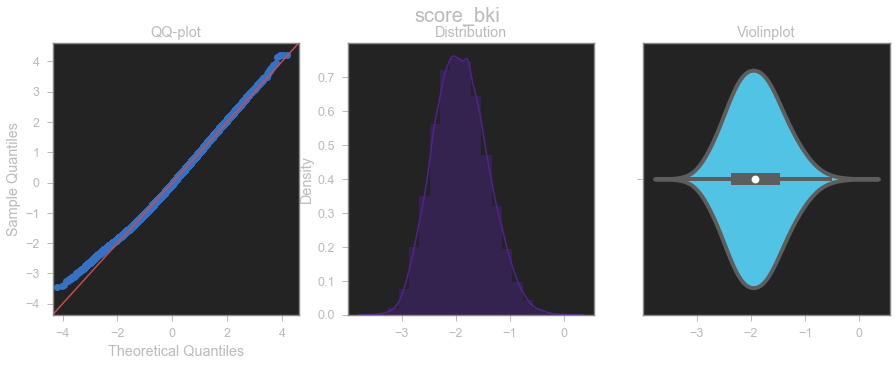

Lower Bound: -3.294, Upper Bound -0.535, Outliers Count: 351


In [27]:
for col in num_cols:
    get_num_info(df_train[col],title=col)
    detect_outliers(df_train[col])

Looking at QQ plots, we may note, that only column ***score_bki*** has a distribution close to normal. Moreover, as was mentioned above, seems this feature already scaled. ***Age*** has left-biased distribution. Data has outliers, but later we will decide what to do with it. 

We have several options: 1. Apply logarithm  function do data, convert some data to categorical features, Apply combination of logarithm and converting to categorical features.

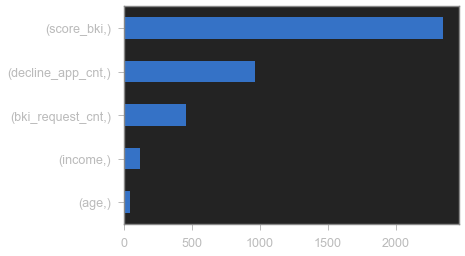

In [28]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[
                    0], index=[num_cols])
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Rank of Matrix: 5
Determinat of matrix: 0.8922
Shape of matrix: (5, 5)


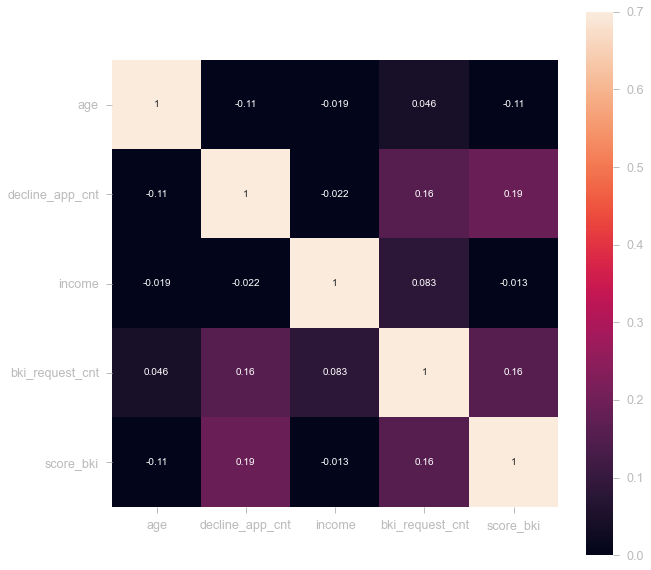

In [29]:
corr_matrix(df_train[num_cols])

Most statistically significant variables are Score_bki, decline_app_cnt.  There is no strong correlations between features. It is confirmed by rank of matrix. The value of determinant is good, there is an inverse matrix.

<a id="sec6.4"></a>
## [Date_Time analysis](#sec6.4)

In [31]:
df_train['app_date'] = pd.to_datetime(
    df_train['app_date'])  # Преобразуем в datetime
df_train['weekend'] = df_train['app_date'].apply(
    lambda x: (if_weekend(x)))  # Флаг выходного дня
# df_train['days_numb'] = df_train['app_date'].apply(
#     lambda x: (get_days_count(x)))  # Порядковый номер дня в году
df_train['days_beetwen'] = df_train['app_date'].apply(
    lambda x: (get_days_beetwen(x)
               ))  # Кол- во дней между подачей заявки и сегодняшним числом
df_train['month'] = df_train['app_date'].apply(lambda x: (month(x)))
df_train = df_train.drop('app_date', axis=1)  # Удалим столбец app_date

In [33]:
df_train['month'].value_counts()

3    21178
2    18028
4    17683
1    16910
Name: month, dtype: int64

Well, our dataset has only four (4) monts. That is not enough what could seems, but better than nothing

Let's see is there any relationships between target data and dates.

In [44]:
num_cols = [
    'age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki',
    'days_beetwen'
]
cat_cols = [
    'education', 'region_rating', 'home_address', 'work_address', 'sna',
    'first_time', 'weekend', 'month'
]

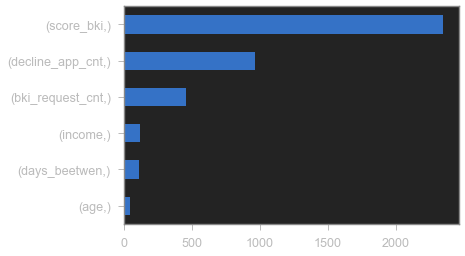

In [47]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[
                    0], index=[num_cols])
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Added feature **days_beetwen** has no significant impact. However it has more than **age**. Keep this feature. 

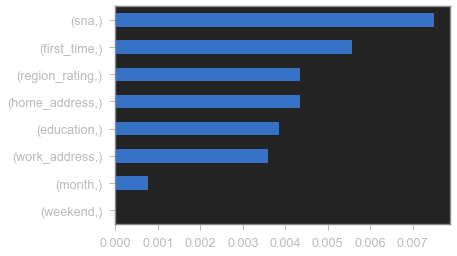

In [46]:
imp_cat = pd.Series(mutual_info_classif(df_train[cat_cols], df_train['default'], 
                                     discrete_features=True), index=[cat_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Rank of Matrix: 8
Determinat of matrix: 0.2891
Shape of matrix: (8, 8)


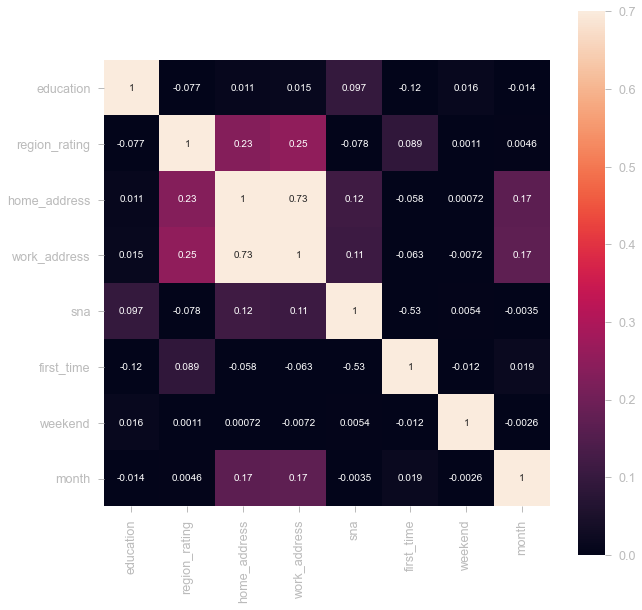

In [38]:
corr_matrix(df_train[cat_cols])

Feature **Month** has statistic significance.However, the flag whether is day weekend or working day has no impact on a target. We will remove it.

Let's see full correlation matrix

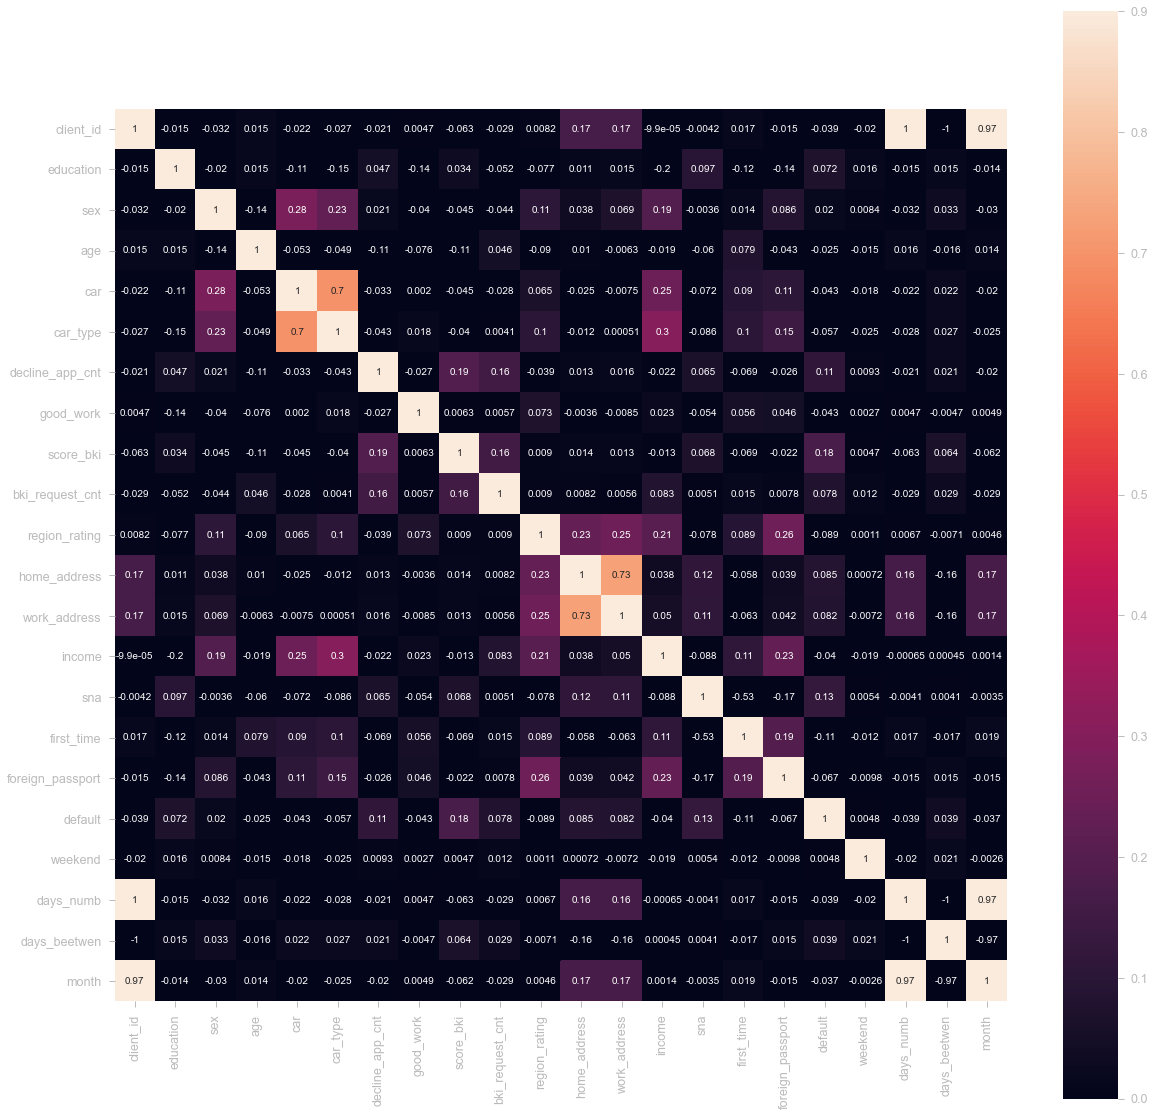

In [62]:
corr_matrix(df_train.drop(['sample'],axis=1),det=False,pltx=20,plty=20)

We can see the complete correlation of the **client_id** and **days_num** features (the ordinal number of the day in the year). This indicates a certain system of assigning a customer number. Most likely, these signs will not give us anything useful.

***car_type*** has correlation with income. It can be explained by assumption that if borrower has more income then he has better car and vice versa.

***sna*** has quite strong correlation with ***foreign_passport***

<a id="sec7"></a>
# [Naive Model](#sec7)

In [64]:
X = df_train.drop(['default'], axis=1)
y = df_train['default']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=RANDOM_SEED)

In [66]:
classifier = LogisticRegression()
classifier.fit(X_train,y_train)

LogisticRegression()

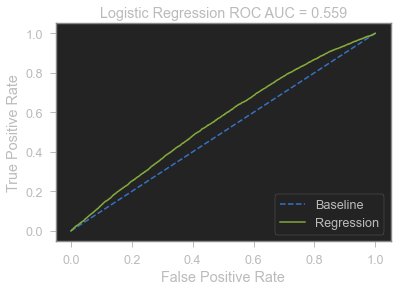

In [67]:
probs = classifier.predict_proba(X_train)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_train, probs)
roc_auc = roc_auc_score(y_train, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [68]:
y_pred = classifier.predict(X_train)
f1_1 = f1_score(y_train,y_pred)
print(f1_1)

0.0


In [69]:
tn,fp,fn,tp = confusion_matrix(y_train,y_pred).ravel()

In [70]:
print(tn)
print(fp)
print(fn)
print(tp)

51566
0
7473
0


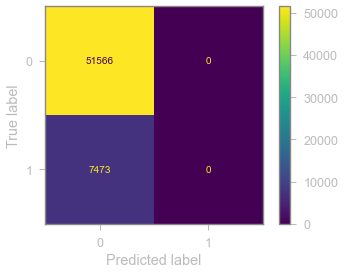

In [71]:
plot_confusion_matrix(classifier.fit(X_train,y_train),X_train,y_train)

In [72]:
df_train['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

<a id="sec8"></a>
# [Feature Engineering](#sec8)

1. Объединить кар и кар тайп

2. Сделать градацию возраста. (Label_enc)

3. Удалить ИД клиента

4. Придумать, что сделать с home address Work_address

5. Hot encoding для образования. (One_hot)

6. Перевести в категории decline count, bki_request

7. Сделать градацию заработка (Label_enc)

8. Сделать SVD

9. Рейтиенг региона в категрию

9. Жахнуть по Багдаду

Chek missing data

In [ ]:
df.isnull().sum()

Let's fix missing data

In [ ]:
df['education'] = df['education'].fillna(
    df['education'].value_counts().index[0])

Create lists with depicted types of data

In [ ]:
bin_cols = ['sex','car','car_type','good_work','foreign_passport']
cat_cols = ['education','home_address','work_address']
num_cols = ['age','decline_app_cnt','income','bki_request_cnt']

Check the distrinution of numeric columns

In [ ]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

BLA BLA

In [ ]:
df1 = df.copy()
for col in num_cols:
    df1[col] = df[col].apply(lambda x: np.log(x+1))

In [ ]:
for i in num_cols:
    plt.figure(figsize=(20, 3))
    plt.subplot(121)
    sns.distplot(df1[i].values, bins=20, color=colors[1])
    plt.title('variable distribution\n' + i, fontsize=15)
    plt.xlabel(i)
    plt.ylabel('Quantity (frequency)')

    plt.subplot(122)
    sns.boxplot(x = 'default',y = i,data=df1)
    plt.title('variable distribution\n' + i, fontsize=15)
    plt.xlabel(i)

<a id="sec5.1"></a>
## [Correclation](#sec5.1)

In [ ]:
sns.heatmap(df[num_cols].corr().abs(),vmin=0,vmax=1,annot=True,square=True)

<a id="sec5.2"></a>
## [Significance of continuous variables ](#sec5.2)

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели

In [ ]:
from sklearn.feature_selection import f_classif

In [ ]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<a id="sec6"></a>
# [Categorical Vars](#sec6)

Самый простой способ — отобразить каждое значение категории в уникальное число. Например, в поле sex значение sex = female преобразовать в , а sex = male — в . Эту простую операцию приходится делать достаточно часто, поэтому в модуле sklearn.preprocessing именно для этой задачи реализован класс LabelEncoder.

Метод fit этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод transform непосредственно преобразует значения в числа. После fit у label_encoder будет доступно поле classes_, содержащее все уникальные значения. Можно их пронумеровать и убедиться, что преобразование выполнено верно.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
mapped_education = pd.Series(label_encoder.fit_transform(df['sex']))
print(dict(enumerate(label_encoder.classes_)))

Сработало! Теперь всегда можно обратиться к classes_ , если забыли, что закодировали. Применим LabelEncoder ко всему набору бинарных переменных.

In [ ]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
df2 = df.copy()

In [ ]:
for column in cat_cols:
    df2[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df2.head()

In [ ]:
imp_cat = pd.Series(mutual_info_classif(df2[bin_cols + cat_cols], df2['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# Подготовка данных к машинному обучению

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

In [ ]:
X_cat.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(df[num_cols].values)

In [ ]:
# Объединяем

X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score

In [ ]:
probs = classifier.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
f1 = f1_score(y_test,y_pred)
print(f1)

In [ ]:
y_pred.sum()

In [ ]:
y_test.sum()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=100000)
model.fit(X_train,y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
f1 = f1_score(y_test,y_pred)
print(f1)

In [ ]:
probs = classifier.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()